In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report

In [8]:
image_size = (256,256)
batch = 32

train = keras.preprocessing.image_dataset_from_directory(
'/kaggle/input/satellite-image-classification/data/',
validation_split=0.2,
subset='training',
seed=42,
image_size=image_size,
batch_size=batch,
label_mode='categorical')

Found 5631 files belonging to 4 classes.
Using 4505 files for training.


In [9]:
validation = keras.preprocessing.image_dataset_from_directory(
'/kaggle/input/satellite-image-classification/data/',
validation_split=0.2,
subset='validation',
seed=42,
image_size=image_size,
batch_size=batch,
label_mode='categorical')

Found 5631 files belonging to 4 classes.
Using 1126 files for validation.


In [14]:
def display_samples(dataset,n_sample,classes_name):
    plt.figure(figsize=(12,10))
    for images, labels in dataset.take(1):
        for i in range(n_sample):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(classes_name[np.argmax(labels[i])])
            plt.axis('off')

(256, 256, 3)


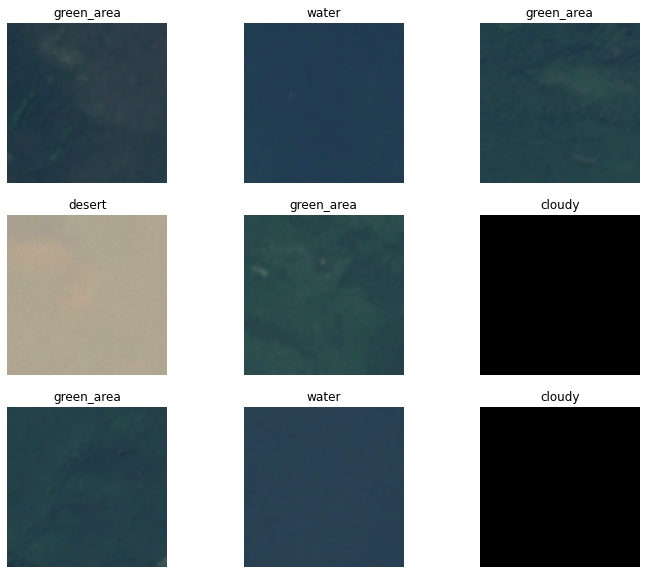

In [27]:
display_samples(train,9,train.class_names)
for images, labels in train.take(1):
    for i in range(1):
        print(images[i].shape)

In [26]:
class_names = train.class_names
labels = np.array([])
for _,label in train:
    labels = np.concatenate((labels,np.argmax(label,axis=-1)))
_,counts = np.unique(labels,return_counts=True)
counts

array([1233,  907, 1182, 1183])

In [28]:
input_shape = (image_size[0], image_size[1],3)
reg = keras.regularizers.l2(0.0005)

model = keras.Sequential()
model.add(Conv2D(32,(3,3),padding='same',activation='relu', input_shape=image_size+(3,),kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='same',activation='relu', input_shape=image_size+(3,),kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),padding='same',activation='relu', input_shape=image_size+(3,),kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(train.class_names), activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 128)       0

In [30]:
model.compile(
loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

epochs = 8
model.fit(train,epochs=epochs,validation_data=validation)

Epoch 1/8
141/141 [==============================] - 239s 2s/step - loss: 0.4381 - accuracy: 0.8189 - val_loss: 0.3497 - val_accuracy: 0.8766
Epoch 2/8
141/141 [==============================] - 234s 2s/step - loss: 0.3158 - accuracy: 0.8713 - val_loss: 0.3681 - val_accuracy: 0.8091
Epoch 3/8
141/141 [==============================] - 242s 2s/step - loss: 0.2779 - accuracy: 0.8957 - val_loss: 0.4518 - val_accuracy: 0.8028
Epoch 4/8
141/141 [==============================] - 231s 2s/step - loss: 0.2517 - accuracy: 0.9048 - val_loss: 0.4399 - val_accuracy: 0.8499
Epoch 5/8
141/141 [==============================] - 232s 2s/step - loss: 0.2746 - accuracy: 0.8930 - val_loss: 0.2219 - val_accuracy: 0.9165
Epoch 6/8
141/141 [==============================] - 230s 2s/step - loss: 0.2720 - accuracy: 0.8926 - val_loss: 0.3506 - val_accuracy: 0.8464
Epoch 7/8
141/141 [==============================] - 228s 2s/step - loss: 0.2530 - accuracy: 0.9010 - val_loss: 0.2258 - val_accuracy: 0.9094
Epoch 

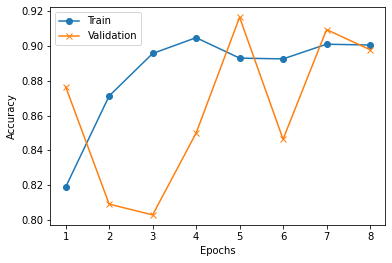

In [34]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range,model.history.history['accuracy'],'-o',label='Train')
plt.plot(epochs_range,model.history.history['val_accuracy'], '-x', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend()
plt.show()

_Seems like the model is overfitted, need to reduce the convolutional layers OR increase the size of validation set (im def not doing that today tho :p)_

In [36]:
y_pred = np.argmax(model.predict(validation),axis=-1)

predictions = np.array([])
labels = np.array([])
for x,y in validation:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x),axis=-1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

<AxesSubplot:>

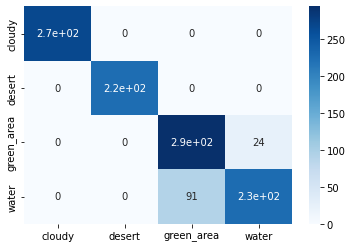

In [37]:
conf = tf.math.confusion_matrix(labels=labels, predictions=predictions)
sns.heatmap(conf,annot=True, cmap='Blues',yticklabels=class_names, xticklabels=class_names)

so, the model is getting confused between some of the water and green area images (fair enough considering the images(not really tho))